# Ungraded Lab: Fairness Indicators

En este cuaderno de laboratorio, utilizarás [Fairness Indicators](https://www.tensorflow.org/tfx/guide/fairness_indicators) para explorar el atributo `Smiling` en un conjunto de datos de imágenes faciales a gran escala. Fairness Indicators es un conjunto de herramientas construidas sobre [TensorFlow Model Analysis](https://www.tensorflow.org/tfx/model_analysis/get_started) que permiten la evaluación regular de métricas de equidad en pipelines de productos. Este [Vídeo introductorio](https://www.youtube.com/watch?v=pHT-ImFXPQo) proporciona más detalles y contexto sobre el escenario del mundo real presentado aquí, una de las principales motivaciones para crear Fairness Indicators. Este cuaderno le enseñará a:


* Entrenar un modelo de red neuronal simple para detectar la sonrisa de una persona en imágenes usando [TF Keras](https://www.tensorflow.org/guide/keras) y el conjunto de datos [CelebFaces Attributes (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).
* Evaluar el rendimiento del modelo contra una métrica de equidad comúnmente utilizada a través de grupos de edad utilizando Indicadores de Equidad.

*Créditos: Parte del código y las discusiones se han tomado de este [Tensorflow tutorial](https://colab.research.google.com/github/tensorflow/fairness-indicators/blob/master/g3doc/tutorials/Fairness_Indicators_TFCO_CelebA_Case_Study.ipynb).*

## Install Fairness Indicators

This will install all related libraries such as TFMA and TFDV.

In [1]:
!pip install --use-deprecated=legacy-resolver fairness-indicators

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 KB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.2/526.2 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 KB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━

*Nota: En Google Colab, es necesario reiniciar el tiempo de ejecución en este punto para finalizar la actualización de los paquetes que acaba de instalar. Puede hacerlo haciendo clic en "Reiniciar tiempo de ejecución" al final de la celda de salida anterior (después de la instalación), o seleccionando "Tiempo de ejecución > Reiniciar tiempo de ejecución" en la barra de menús. **Por favor, no continúe con la siguiente sección sin reiniciar.** También puede ignorar los errores sobre incompatibilidad de versiones de algunos de los paquetes incluidos, ya que no los utilizaremos en este cuaderno.

## Import packages

A continuación, importará los paquetes principales y algunas utilidades que necesitará en este cuaderno. Tenga en cuenta que no está importando `fairness-indicators` directamente. Como se mencionó en la introducción, este conjunto de herramientas se construye en la parte superior de TFMA por lo que sólo puede importar TFMA para acceder a ella.

In [2]:
import tensorflow as tf
import tensorflow_model_analysis as tfma
import tensorflow_datasets as tfds
from tensorflow import keras

El código siguiente no debería producir ningún error. En caso contrario, reinicie la instalación.

In [3]:
print("TensorFlow " + tf.__version__)
print("TFMA " + tfma.VERSION_STRING)

TensorFlow 2.11.0
TFMA 0.43.0


## Download and prepare the dataset

[CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) es un conjunto de datos de atributos faciales a gran escala con más de 200.000 imágenes de famosos, cada una con 40 anotaciones de atributos (como tipo de pelo, accesorios de moda, rasgos faciales, etc.) y 5 ubicaciones de puntos de referencia (posiciones de ojos, boca y nariz). Para más detalles, puede consultar [este artículo](https://liuziwei7.github.io/projects/FaceAttributes.html).

Con el permiso de los propietarios, este conjunto de datos se almacena en Google Cloud Storage (GCS) y se accede a él principalmente a través de [TensorFlow Datasets(`tfds`)](https://www.tensorflow.org/datasets). Para ahorrar tiempo de descarga y espacio en disco, se utilizará el bucket GCS especificado a continuación como directorio de datos. Este ya contiene los TFRecords. Si quieres descargarlo a tu espacio de trabajo, puedes pasar un directorio local al argumento `data_dir`. Ten en cuenta que la descarga tardará en completarse.



In [5]:
# URI of the dataset in Goocle Cloud Storage
GCS_BASE_DIR = "gs://celeb_a_dataset/"

# Load the data using TFDS
data, data_info = tfds.load("celeb_a", data_dir=GCS_BASE_DIR, with_info=True, builder_kwargs={'version':'2.0.0'})

Puede previsualizar algunas de las imágenes del conjunto de datos.

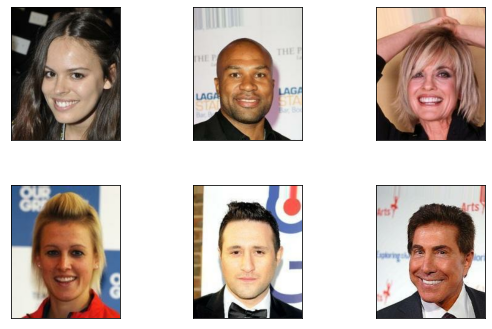

In [6]:
# Take 6 examples and preview images
fig = tfds.show_examples(data['train'].take(6), data_info)

También puede ver el conjunto de datos como un marco de datos para previsualizar los demás atributos en formato tabular.

In [7]:
# Take 4 examples as a dataframe
df = tfds.as_dataframe(data['train'].take(4), data_info)

# View the dataframe
df.head()

attributes/5_o_Clock_Shadow  attributes/Arched_Eyebrows  \
0                        False                       False   
1                         True                        True   
2                        False                       False   
3                        False                       False   

   attributes/Attractive  attributes/Bags_Under_Eyes  attributes/Bald  \
0                   True                       False            False   
1                  False                       False             True   
2                   True                       False            False   
3                   True                       False            False   

   attributes/Bangs  attributes/Big_Lips  attributes/Big_Nose  \
0             False                 True                False   
1             False                 True                 True   
2              True                False                False   
3             False                False                False   

   attributes/Black_Hair  attributes/Blond_Hair  ...  landmarks/lefteye_x  \
0                  False                  False  ...                   68   
1                  False                  False  ...                   69   
2                  False                   True  ...                   68   
3                  False                  False  ...                   69   

   landmarks/lefteye_y  landmarks/leftmouth_x  landmarks/leftmouth_y  \
0                  111                     64                    149   
1                  111                     68                    151   
2                  112                     67                    151   
3                  111                     69                    153   

   landmarks/nose_x  landmarks/nose_y  landmarks/righteye_x  \
0                75               138                   109   
1                90               133                   108   
2                84               132                   109   
3                85               136                   107   

   landmarks/righteye_y  landmarks/rightmouth_x  landmarks/rightmouth_y  
0                   113                     114                     153  
1                   112                     109                     152  
2                   111                     110                     152  
3                   111                     108                     152  

[4 rows x 51 columns]

*Vamos a listar la cabecera de la columna para que puedas ver los nombres de los atributos en el conjunto de datos. Para este cuaderno, sólo examinarás las características `attributes/Young` y `attributes/Smiling` pero siéntete libre de elegir otras características una vez que hayas repasado todo el ejercicio.

In [8]:
# List dataframe header
df.columns

Index(['attributes/5_o_Clock_Shadow', 'attributes/Arched_Eyebrows',
       'attributes/Attractive', 'attributes/Bags_Under_Eyes',
       'attributes/Bald', 'attributes/Bangs', 'attributes/Big_Lips',
       'attributes/Big_Nose', 'attributes/Black_Hair', 'attributes/Blond_Hair',
       'attributes/Blurry', 'attributes/Brown_Hair',
       'attributes/Bushy_Eyebrows', 'attributes/Chubby',
       'attributes/Double_Chin', 'attributes/Eyeglasses', 'attributes/Goatee',
       'attributes/Gray_Hair', 'attributes/Heavy_Makeup',
       'attributes/High_Cheekbones', 'attributes/Male',
       'attributes/Mouth_Slightly_Open', 'attributes/Mustache',
       'attributes/Narrow_Eyes', 'attributes/No_Beard', 'attributes/Oval_Face',
       'attributes/Pale_Skin', 'attributes/Pointy_Nose',
       'attributes/Receding_Hairline', 'attributes/Rosy_Cheeks',
       'attributes/Sideburns', 'attributes/Smiling',
       'attributes/Straight_Hair', 'attributes/Wavy_Hair',
       'attributes/Wearing_Earrings', 'a

In this notebook:
* Tu modelo intentará clasificar si el sujeto de la imagen está sonriendo, representado por el atributo `Smiling`<sup>*</sup>.
* Las imágenes se redimensionarán de 218x178 a 28x28 para reducir el tiempo de ejecución y la memoria durante el entrenamiento.
* El rendimiento de su modelo se evaluará a través de grupos de edad, utilizando el atributo binario "Joven". You will call this "age group" in this notebook.

___

<sup>*</sup> *Aunque hay poca información disponible sobre la metodología de etiquetado de este conjunto de datos, asumirá que el atributo "Sonriente" fue determinado por una expresión de placer, amabilidad o diversión en la cara del sujeto. En este ejemplo, se tomarán estas etiquetas como verdades básicas.

### Caveats
Antes de seguir adelante, hay que tener en cuenta varias consideraciones a la hora de utilizar CelebA:
* Aunque, en principio, este cuaderno podría utilizar cualquier conjunto de datos de imágenes de caras, se eligió CelebA porque contiene imágenes de dominio público de personajes públicos.
* Todas las anotaciones de atributos en CelebA se operacionalizan como categorías binarias. Por ejemplo, el atributo "joven" (determinado por los etiquetadores del conjunto de datos) se indica como presente o ausente en la imagen.
* Las categorizaciones de CelebA no reflejan la diversidad humana real de los atributos.
* A efectos de este cuaderno, la característica que contiene el atributo `Young` se denomina "grupo de edad". Un `True` colocará la imagen como miembro del grupo de edad `Young` y un `False` colocará la imagen como miembro del grupo de edad `Not Young`. Se trata de suposiciones, ya que esta información no se menciona en el [documento original](http://openaccess.thecvf.com/content_iccv_2015/html/Liu_Deep_Learning_Face_ICCV_2015_paper.html).
* Como tal, el rendimiento de los modelos entrenados en este cuaderno está ligado a la forma en que los atributos han sido operacionalizados y anotados por los autores de CelebA.
* Este modelo no debe utilizarse con fines comerciales, ya que violaría [el acuerdo de investigación no comercial de CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).

### Setting Up Input Functions

Ahora, definirá las funciones de preprocesamiento para preparar sus datos como entradas del modelo. Entre ellas se incluyen el cambio de tamaño de las imágenes, la normalización de los píxeles, la conversión al tipo de datos correcto y la agrupación de las características y las etiquetas.

In [9]:
# Define Constants
ATTR_KEY = "attributes"
IMAGE_KEY = "image"
LABEL_KEY = "Smiling"
GROUP_KEY = "Young"
IMAGE_SIZE = 28

# Define Preprocessing Function
def preprocess_input_dict(feat_dict):
  ''' Elige los atributos a estudiar y redimensiona las imágenes
  Args:
    feat_dict (diccionario): características del conjunto de datos

  Devuelve
    diccionario que contiene la imagen redimensionada, la etiqueta y el grupo de edad
  '''
  # Separate out the image and target variable from the feature dictionary.
  image = feat_dict[IMAGE_KEY]
  label = feat_dict[ATTR_KEY][LABEL_KEY]
  group = feat_dict[ATTR_KEY][GROUP_KEY]

  # Resize and normalize image.
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
  image /= 255.0

  # Cast label and group to float32.
  label = tf.cast(label, tf.float32)
  group = tf.cast(group, tf.float32)

  # Put the computed values in a dictionary
  feat_dict[IMAGE_KEY] = image
  feat_dict[ATTR_KEY][LABEL_KEY] = label
  feat_dict[ATTR_KEY][GROUP_KEY] = group

  return feat_dict

# Define lambda functions to group features and labels for training and evaluation
get_image_and_label = lambda feat_dict : (feat_dict[IMAGE_KEY], feat_dict[ATTR_KEY][LABEL_KEY])
get_image_label_and_group = lambda feat_dict : (feat_dict[IMAGE_KEY], feat_dict[ATTR_KEY][LABEL_KEY], feat_dict[ATTR_KEY][GROUP_KEY])

## Prepare train and test splits

La siguiente función de ayuda le ayudará a dividir, mezclar, procesar por lotes y preprocesar sus datos de entrenamiento. Para este cuaderno, sólo desarrollará un modelo que acepta la imagen como entrada y emite el atributo `Smiling` (es decir, etiqueta).

In [10]:
def celeb_a_train_data_wo_group(data, batch_size):
  '''
  Args:
    data (TF dataset) - dataset to preprocess
    batch_size (int) - batch size
  
  Returns:
    Batches of preprocessed datasets containing tuples with (image, label)
  '''
  celeb_a_train_data = data.shuffle(1024).repeat().batch(batch_size).map(preprocess_input_dict)
  return celeb_a_train_data.map(get_image_and_label)

La división `test` no necesita ser barajada por lo que puedes simplemente preprocesarla como se indica a continuación.

In [11]:
# Prepare test data
celeb_a_test_data = data['test'].batch(1).map(preprocess_input_dict).map(get_image_label_and_group)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Como comprobación, puede examinar el contenido de un ejemplo de los datos de prueba. Debería ver que se ha remodelado correctamente y que los píxeles deberían estar normalizados.

In [12]:
# Print info about the test data records
for sample in celeb_a_test_data.take(1):
  print(f'Data type: {type(sample)}')
  print(f'Number of elements: {len(sample)}')
  print(f'Shape of 1st element: {sample[0].shape}')
  print(f'Shape of 2nd element: {sample[1].shape}')
  print(f'Shape of 3rd element: {sample[2].shape}')
  print(f'Contents: \n{sample}')

Data type: <class 'tuple'>
Number of elements: 3
Shape of 1st element: (1, 28, 28, 3)
Shape of 2nd element: (1,)
Shape of 3rd element: (1,)
Contents: 
(<tf.Tensor: shape=(1, 28, 28, 3), dtype=float32, numpy=
array([[[[0.81317526, 0.7912615 , 0.72465986],
         [0.85708785, 0.83748   , 0.7542867 ],
         [0.8946379 , 0.86615646, 0.77189875],
         ...,
         [0.527636  , 0.3903811 , 0.16293013],
         [0.5096639 , 0.3841737 , 0.15280116],
         [0.5019608 , 0.3882353 , 0.15294118]],

        [[0.7951531 , 0.75985897, 0.69963485],
         [0.7954932 , 0.7562775 , 0.7156613 ],
         [0.80069023, 0.76064926, 0.7249299 ],
         ...,
         [0.5149909 , 0.3777361 , 0.1502851 ],
         [0.50980395, 0.38431373, 0.15294118],
         [0.5019608 , 0.3882353 , 0.15294118]],

        [[0.74019605, 0.6931372 , 0.6382353 ],
         [0.757418  , 0.71035916, 0.6554572 ],
         [0.7790216 , 0.7319077 , 0.6804222 ],
         ...,
         [0.49884957, 0.3802521 , 0.15848

## Build a simple DNN Model

Con el conjunto de datos preparado, ahora montaremos un modelo simple `tf.keras.Sequential` para clasificar las imágenes. El modelo consiste en:

1. Una capa de entrada que representa la imagen aplanada de 28x28x3.
2. Una capa completamente conectada con 64 unidades activadas por una función ReLU.
3. 3. Una capa de lectura de una sola unidad para obtener puntuaciones reales en lugar de probabilidades.

Usted puede ser capaz de mejorar en gran medida el rendimiento del modelo mediante la adición de cierta complejidad (por ejemplo, capas más densamente conectadas, explorando diferentes funciones de activación, aumentando el tamaño de la imagen), pero eso puede distraer del objetivo de demostrar lo fácil que es aplicar los indicadores cuando se trabaja con Keras. Por esa razón, primero mantendrás el modelo simple - pero siéntete libre de explorar este espacio más tarde.

In [13]:
def create_model():
  '''Builds the simple DNN binary classifier'''

  # Build the model using the Sequential API
  model = keras.Sequential([
      keras.layers.Flatten(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='image'),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(1, activation=None)
  ])

  # Compile the model with hinge loss and binary accuracy metric
  model.compile(
      optimizer=tf.keras.optimizers.Adam(0.001),
      loss='hinge',
      metrics='binary_accuracy')
  
  return model


## Train & Evaluate Model

Ahora estás listo para entrenar tu modelo. Para reducir el tiempo de ejecución y la memoria, entrenarás el modelo dividiendo los datos en pequeños lotes con pocas iteraciones repetidas.

In [14]:
BATCH_SIZE = 32

# Build the model
model = create_model()

# Train the model
model.fit(celeb_a_train_data_wo_group(data['train'], BATCH_SIZE), epochs=5, steps_per_epoch=1000)

Epoch 1/5
1000/1000 [==============================] - 71s 44ms/step - loss: 0.5006 - binary_accuracy: 0.7750
Epoch 2/5
1000/1000 [==============================] - 41s 41ms/step - loss: 0.3833 - binary_accuracy: 0.8298
Epoch 3/5
1000/1000 [==============================] - 41s 41ms/step - loss: 0.3524 - binary_accuracy: 0.8450
Epoch 4/5
1000/1000 [==============================] - 41s 41ms/step - loss: 0.3503 - binary_accuracy: 0.8448
Epoch 5/5
1000/1000 [==============================] - 38s 38ms/step - loss: 0.3322 - binary_accuracy: 0.8533


La evaluación del modelo con los datos de prueba debería arrojar una puntuación final de precisión ligeramente superior al 85%. No está mal para un modelo sencillo sin ajustes finos.

In [15]:
# Evaluate trained model on the test data
results = model.evaluate(celeb_a_test_data)

19962/19962 [==============================] - 75s 4ms/step - loss: 0.2624 - binary_accuracy: 0.8124


A continuación, guarde el modelo para poder analizarlo en la sección siguiente.

In [16]:
# Define model directory
MODEL_LOCATION = 'saved_model'

# Save the model
model.save(MODEL_LOCATION, save_format='tf')

## Model Analysis

Como ya sabe, no suele bastar con medir el rendimiento de su modelo en función de parámetros globales. Por ejemplo, el rendimiento evaluado entre grupos de edad puede revelar algunas deficiencias.

Para profundizar en esta cuestión, evaluará el modelo con indicadores de equidad a través de TFMA. En concreto, comprobará si existe una diferencia significativa en el rendimiento entre las categorías "Joven" y "No joven" cuando se evalúa la tasa de falsos positivos (FPR).

Un falso positivo se produce cuando el modelo predice incorrectamente la clase positiva. En este contexto, se produce un resultado falso positivo cuando la verdad básica es una imagen de un famoso "No sonriente" y el modelo predice "Sonriente". Aunque esto parece un error relativamente mundano, los falsos positivos a veces pueden causar comportamientos más problemáticos cuando se implementan en una aplicación del mundo real. Por ejemplo, un error falso positivo en un clasificador de spam puede hacer que un usuario pierda un correo electrónico importante.

En general, seguirá los mismos pasos que en el primer laboratorio no calificado de esta semana. A saber:

* Create a TFRecord of the test dataset.
* Write an `EvalConfig` file
* Create an `EvalSharedModel`
* Define a `Schema` message
* Run model analysis with TFMA

### Create TFRecord

Necesitará serializar el conjunto de datos de prueba preprocesado para que pueda ser leído por TFMA. Hemos proporcionado una función de ayuda para hacerlo. Observe que la característica de grupo de edad se transforma en una cadena ("Joven" o "No joven"). Esto será útil en la visualización para que las etiquetas sean más fáciles de interpretar (en comparación con sólo 1 o 0).

In [17]:
# Define filename
TFRECORD_FILE = 'celeb_a_test.tfrecord'

In [18]:
def celeb_ds_to_tfrecord(dataset, tfrecord_file):
  ''' Helper function to convert a TF Dataset to TFRecord

  Args:
    dataset (TF Dataset) - dataset to save as TFRecord
    tfrecord_file (string) - filename to use when writing the TFRecord
  '''

  # Initialize examples list
  examples = []

  for row in dataset:
    # Get image, label, and group tensors
    image = row[0]
    label = row[1]
    group = row[2]

    # Flatten image
    image = tf.reshape(image, [-1])

    # Instantiate Example
    output = tf.train.Example()

    # Assign features' numpy arrays to the Example feature values
    output.features.feature[IMAGE_KEY].float_list.value.extend(image.numpy().tolist())
    output.features.feature[LABEL_KEY].float_list.value.append(label.numpy()[0])
    output.features.feature[GROUP_KEY].bytes_list.value.append(b"Young" if group.numpy()[0] else b'Not Young')
    
    # Append to examples list
    examples.append(output)

  # Serialize examples and save as tfrecord
  with tf.io.TFRecordWriter(tfrecord_file) as writer:
    for example in examples:
      writer.write(example.SerializeToString())

In [19]:
# Use the helper function to serialize the test dataset
celeb_ds_to_tfrecord(celeb_a_test_data, TFRECORD_FILE)

### Write EvalConfig file

A continuación, definirá el modelo, las métricas y las especificaciones de corte en un archivo de configuración de la evaluación. Como ya se ha mencionado, dividirá los datos por grupos de edad para ver si existe un problema subyacente. Para las métricas, se incluirá la clase `FairnessIndicators`. Se trata de métricas de equidad comúnmente identificadas para clasificadores binarios y multiclase. Además, configurará una lista de umbrales. Éstos le permitirán observar si el modelo predice mejor cuando se cambia el umbral para determinar entre las dos clases (por ejemplo, ¿será menor el FPR si el modelo predice "Sonriente" para salidas superiores a 0,22?)


In [20]:
# Import helper module
from google.protobuf import text_format

# Write EvalConfig string
eval_config_pbtxt = """
      model_specs {
        label_key: "%s"
      }
      metrics_specs {
        metrics {
          class_name: "FairnessIndicators"
          config: '{ "thresholds": [0.22, 0.5, 0.75] }'
        }
        metrics {
          class_name: "ExampleCount"
        }
      }
      slicing_specs {}
      slicing_specs { feature_keys: "%s" }
    """ % (LABEL_KEY, GROUP_KEY)

# Parse as a Message
eval_config = text_format.Parse(eval_config_pbtxt, tfma.EvalConfig())

### Create EvalSharedModel

Esto será idéntico al comando que ejecutó en un laboratorio anterior. Esto es necesario para que TFMA sepa cómo cargar y configurar su modelo desde el disco.

In [21]:
# Create EvalSharedModel
eval_shared_model = tfma.default_eval_shared_model(
      eval_saved_model_path=MODEL_LOCATION, eval_config=eval_config)

### Create a Schema

Este es un paso adicional de su flujo de trabajo TFMA anterior. Es necesario sobre todo porque, a diferencia del laboratorio sin calificar TFMA, usted no incluyó una firma de servicio con el modelo. Si recuerda, la función llamada por esa firma se encargaba de analizar los tfrecords, convertirlos al tipo de datos correcto y preprocesarlos. Dado que esa parte no se incluye en este laboratorio, tendrá que proporcionar un esquema para que TFMA sepa qué tipos de datos hay en los ejemplos serializados cuando analice el tfrecord en un diccionario de características. También tendrá que definir las dimensiones de la imagen, ya que es lo que se espera de su modelo de entrada. Eso es manejado por el `tensor_representation_group` a continuación.

In [22]:
from tensorflow_metadata.proto.v0 import schema_pb2
from google.protobuf import text_format

# Define Schema message as string
schema_pbtxt = """
      tensor_representation_group {
        key: ""
        value {
          tensor_representation {
            key: "%s"
            value {
              dense_tensor {
                column_name: "%s"
                shape {
                  dim { size: 28 }
                  dim { size: 28 }
                  dim { size: 3 }
                }
              }
            }
          }
        }
      }
      feature {
        name: "%s"
        type: FLOAT
      }
      feature {
        name: "%s"
        type: FLOAT
      }
      feature {
        name: "%s"
        type: BYTES
      }
      """ % (IMAGE_KEY, IMAGE_KEY, IMAGE_KEY, LABEL_KEY, GROUP_KEY)

# Parse the schema string to a message
schema = text_format.Parse(schema_pbtxt, schema_pb2.Schema())

### Run TFMA

Pasarás los objetos que has creado en las secciones anteriores a `tfma.run_model_analysis()`. Como se ha hecho anteriormente, esto se encargará de cargar el modelo y los datos, y el cálculo de las métricas en las rebanadas de datos que ha especificado.

In [23]:
# Define output directory
OUTPUT_PATH = 'tfma_output'

# Run model analysis
eval_results = tfma.run_model_analysis(
    eval_shared_model=eval_shared_model,
    eval_config=eval_config,
    data_location=TFRECORD_FILE,
    schema=schema,
    output_path=OUTPUT_PATH
)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Ahora puede ver las métricas de imparcialidad que ha especificado. La tasa de falsos positivos ya debería estar seleccionada (si no es así, marque la casilla "Tasa de falsos positivos" a la izquierda) y podrá ver que es considerablemente más alta para el grupo de edad "No joven". Intente explorar el widget y vea si puede hacer otras averiguaciones. He aquí algunas sugerencias:

* Cambie el umbral desplegable y vea cómo cambia el FPR con diferentes umbrales.

* Cambie la línea de base a "Joven: Joven" para que la diferencia porcentual (en la tabla debajo del gráfico) se mida con respecto a ella.

* Deseleccione el segmento "Total" para poder comparar los dos grupos de edad.

* Seleccione otras métricas y observe sus gráficos.

In [24]:
# Visualize the fairness metrics
tfma.addons.fairness.view.widget_view.render_fairness_indicator(eval_results)

Tras estudiar las discrepancias en tus predicciones, puedes investigar por qué ocurre y tener un plan para remediarlo. Además de cambiar la arquitectura de su modelo, también puede examinar primero sus datos de entrenamiento. TFDV también incluye `fairness-indicators` para que puedas utilizarlo para generar estadísticas a partir de tus datos. A continuación te explicamos brevemente cómo hacerlo. 

En primer lugar, descargue el conjunto de datos de un bucket GCS en su espacio de trabajo local. Para ello, puede utilizar la herramienta [gsutil](https://cloud.google.com/storage/docs/gsutil).

In [25]:
import tensorflow_data_validation as tfdv

# Define training directory
TRAIN_DIR = f'{GCS_BASE_DIR}celeb_a/2.0.0/celeb_a-train.tfrecord*'

# View tfrecord filenames in GCS
!gsutil ls {TRAIN_DIR}

gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00000-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00001-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00002-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00003-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00004-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00005-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00006-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00007-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00008-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00009-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00010-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00011-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00012-of-00016
gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tf

In [26]:
# Define the data directory
DATA_DIR = 'celeb_a-train-tfrecords'

# Create the data directory
!mkdir {DATA_DIR}

# Download the dataset into the local directory
!gsutil -m cp {TRAIN_DIR} {DATA_DIR}

Copying gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00001-of-00016...
Copying gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00000-of-00016...
Copying gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00002-of-00016...
Copying gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00003-of-00016...
Copying gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00004-of-00016...
Copying gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00005-of-00016...
Copying gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00006-of-00016...
Copying gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00007-of-00016...
Copying gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00008-of-00016...
Copying gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00009-of-00016...
Copying gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00010-of-00016...
Copying gs://celeb_a_dataset/celeb_a/2.0.0/celeb_a-train.tfrecord-00011-of-0

Ahora puede generar las estadísticas para una función específica.

In [28]:
# Filter features to observe
stats_options = tfdv.StatsOptions(feature_allowlist=['attributes/Young'])

# Compute the statistics for all tf records under the data directory
statistics = tfdv.generate_statistics_from_tfrecord(f'{DATA_DIR}/', stats_options=stats_options)

# Visualize the statistics
tfdv.visualize_statistics(statistics)

Las estadísticas muestran que el grupo de edad "No joven" (es decir, "0" en la columna "Atributos/Joven") tiene muy pocas imágenes en comparación con el grupo de edad "Joven". Quizá por eso el modelo aprende mejor con las imágenes "jóvenes". Puede probar a añadir más imágenes "No jóvenes" y ver si el modelo funciona mejor en esta franja.

## Wrap Up

En este laboratorio, ha preparado un conjunto de datos de imágenes y ha entrenado un modelo para predecir uno de sus atributos (es decir, la sonrisa). A continuación, ha dividido los datos por grupos de edad y ha calculado las métricas de equidad del paquete "Indicadores de equidad" a través de TFMA. Aunque el resultado parece sencillo, es un paso importante en los proyectos de ML de producción, ya que no detectar estos problemas puede afectar en gran medida a la experiencia de sus usuarios. Mejorar estas métricas te ayudará a comprometerte con la equidad en tus aplicaciones. Te animamos a que pruebes a explorar más trozos del conjunto de datos y veas a qué conclusiones puedes llegar.

Para más práctica, [aquí](https://colab.research.google.com/github/tensorflow/fairness-indicators/blob/master/g3doc/tutorials/Fairness_Indicators_Example_Colab.ipynb) es un tutorial oficial que utiliza indicadores de equidad en datos de texto. Utiliza la [What-If-Tool](https://pair-code.github.io/what-if-tool/) que es otro paquete que viene con `Indicadores de Equidad`. También podrás explorarlo en la tarea de programación de esta semana.